In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

num_classes = 5
img_rows, img_cols = 32, 32
batch_size = 64


In [2]:
train_data_dir = 'C:/Users/prakash/Desktop/J-Split/train'
validation_data_dir = 'C:/Users/prakash/Desktop/J-Split/val'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size =batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 11854 images belonging to 5 classes.
Found 2966 images belonging to 5 classes.


In [3]:
model = Sequential()

# Padding = 'same'  results in padding the input such that
# the output has the same length as the original input
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape= (img_rows, img_cols, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer and configure some parameters
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

In [4]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


                     
checkpoint = ModelCheckpoint("C:/Users/prakash/Desktop/Project_Prakash/fruits_fresh_6.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer =keras.optimizers.Adam(learning_rate=.001),
              metrics = ['accuracy'])

nb_train_samples = 11854
nb_validation_samples = 2966
epochs = 20

history = model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)


Epoch 1/20
185/185 [==============================] - 204s 1s/step - loss: 0.9966 - accuracy: 0.6243 - val_loss: 1.4130 - val_accuracy: 0.5669

Epoch 00001: val_loss improved from inf to 1.41299, saving model to C:/Users/prakash/Desktop/Project_Prakash\fruits_fresh_6.h5
Epoch 2/20
185/185 [==============================] - 195s 1s/step - loss: 0.2505 - accuracy: 0.9035 - val_loss: 0.0461 - val_accuracy: 0.9844

Epoch 00002: val_loss improved from 1.41299 to 0.04606, saving model to C:/Users/prakash/Desktop/Project_Prakash\fruits_fresh_6.h5
Epoch 3/20
185/185 [==============================] - 182s 980ms/step - loss: 0.0697 - accuracy: 0.9781 - val_loss: 0.1372 - val_accuracy: 0.9463

Epoch 00003: val_loss did not improve from 0.04606
Epoch 4/20
185/185 [==============================] - 131s 704ms/step - loss: 0.0528 - accuracy: 0.9823 - val_loss: 0.0168 - val_accuracy: 0.9929

Epoch 00004: val_loss improved from 0.04606 to 0.01677, saving model to C:/Users/prakash/Desktop/Project_Prak

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
class_labels = validation_generator.class_indices

#Confution Matrix and Classification Report
Y_pred = model.predict(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
#target_names = list(class_labels.values())
target_names =['Apple','Banana','Pineapple','Strawberry','Watermelon']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[1677    0    7    4    0]
 [   0  383    0    0    0]
 [   0    0  361    0    0]
 [   0    0    1  406    0]
 [   0    0    0    0  127]]
Classification Report
              precision    recall  f1-score   support

       Apple       1.00      0.99      1.00      1688
      Banana       1.00      1.00      1.00       383
   Pineapple       0.98      1.00      0.99       361
  Strawberry       0.99      1.00      0.99       407
  Watermelon       1.00      1.00      1.00       127

    accuracy                           1.00      2966
   macro avg       0.99      1.00      1.00      2966
weighted avg       1.00      1.00      1.00      2966



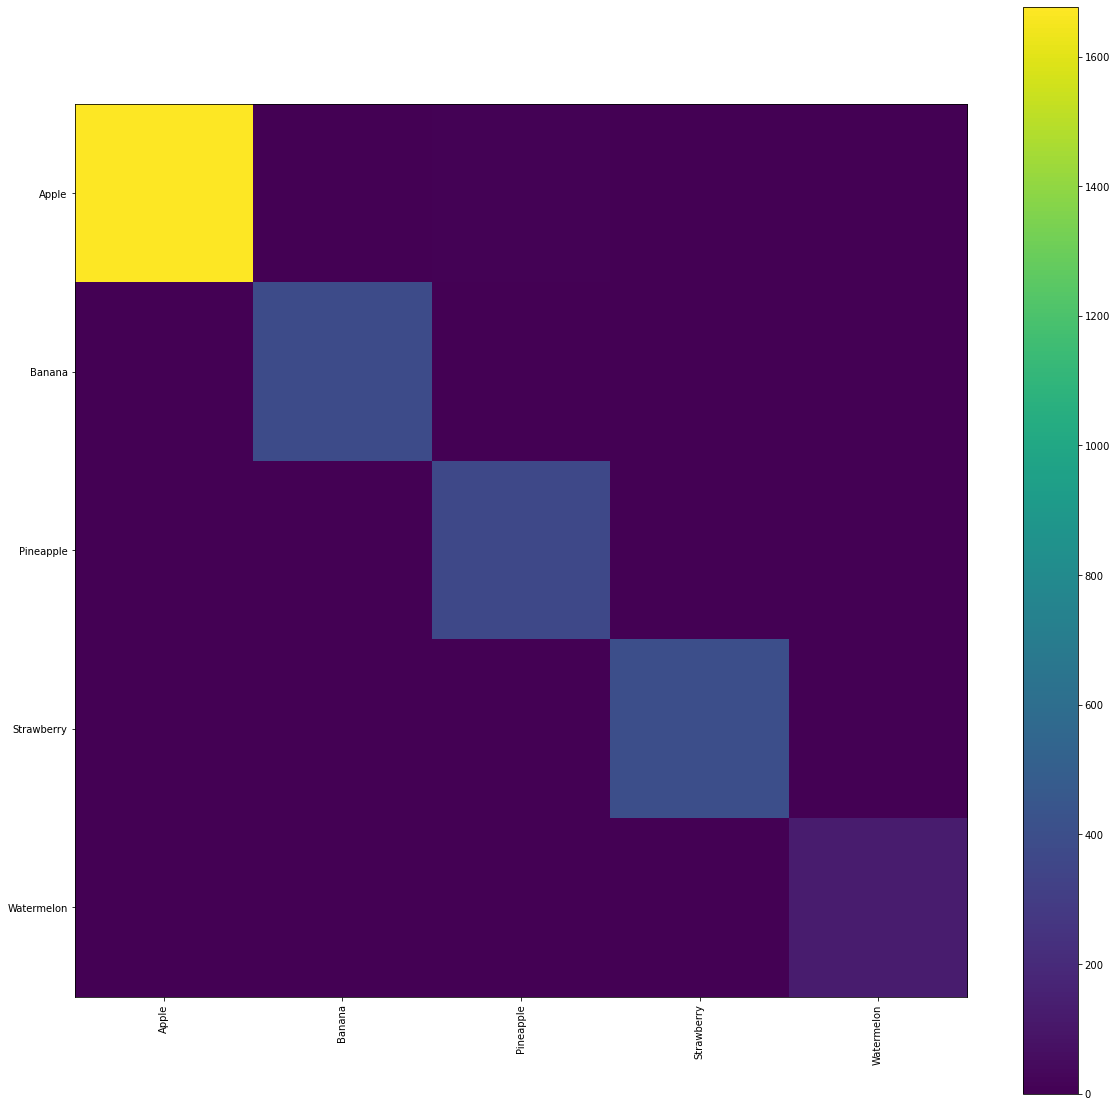

In [6]:

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model

img_row, img_height, img_depth = 32,32,3
model = load_model('C:/Users/prakash/Desktop/Project_Prakash/fruits_fresh_6.h5')

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())



#Confution Matrix and Classification Report
Y_pred = model.predict(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

[[7.2155353e-06 1.1822164e-06 1.9061063e-04 9.9980098e-01 2.9627666e-08]]
The image is Strawberry


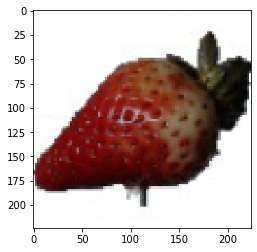

In [8]:
import os
import re
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import tensorflow as tf

from keras.models import load_model
from keras.preprocessing import image

import cv2
from keras.models import load_model
from keras.preprocessing import image
path = 'C:/Users/prakash/Desktop/D/Check/1.jpg' 
predictions = []

#img, final_path, true_label = getRandomImage(path, img_width, img_height)
#files.append(final_path)
#true_labels.append(true_label)
x=image.load_img(path , target_size = (32,32))  
x = image.img_to_array(x)
x = x * 1./255
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

from tensorflow import keras
model = load_model('C:/Users/prakash/Desktop/Project_Prakash/fruits_fresh_6.h5')

classes = model.predict(images, batch_size = 10)
print(classes)
predictions.append(classes)

c=list(max(classes))
max_value = max(c)

img = image.load_img(path,target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)

max_index = c.index(max_value)
#print(max_index)

if(max_index==0):
    print("The image is Apple")
elif(max_index==1):
    print("The image is Banana")
elif(max_index==2):
    print("The image is Pineapple")
elif(max_index==3):
    print("The image is Strawberry")
elif(max_index==4):
    print("The image is Watermelon")
    